You can fing the original paper [here](https://www.arxiv-vanity.com/papers/1406.2661/)

<a href="https://github.com/HSE-LAMBDA/DeepGenerativeModels/blob/master/seminars/seminar-7/GAN-CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from comet_ml import Experiment

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.utils as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_transforms = transforms.Compose([ # Compose combines a number of transforms into one operation
    transforms.ToTensor(), # PIL Image -> Tensor
])

In [0]:
# We can use torchvision package to get MNIST dataset

data_path = "./data/"

train_dataset = datasets.CIFAR10(data_path,
                               train=True,
                               transform=mnist_transforms,
                               target_transform=None,
                               download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)


Files already downloaded and verified


In [0]:
def plot_image(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.detach().cpu().permute(1, 2, 0))
    plt.show()

Label: 4


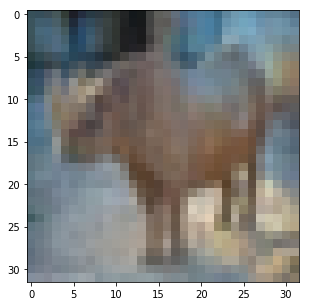

In [0]:
img, label = next(iter(train_loader))
print(f'Label: {label[0]}')
plot_image(img[0])

Наша цель - построить простейший GAN, составленный из двух частей, генератора и дискриминатора.

1. Генератор G принимает на вход шум из какого-то заранее заданного латентного пространства и преобразует его в какую-то картинку заданной размерности (в нашем случае 3x32x32). 
2. Дискриминатор D принимает на вход какую-то картинку заданной размерности и выдает вероятность того что картина - реальная (не сгенерированная)

![im](https://lilianweng.github.io/lil-log/assets/images/GAN.png)

Для обучения такой конструкции мы можем использовать простую бинарную кросс-энтропию:

$$\text{BCE}(\hat{y}, y) = \frac{1}{N} \Sigma^N_{i=0} y_i * \log \hat{y}_i + (1 - y_i) * \log (1 - \hat{y}_i)$$

### D:

С одной стороны, мы хотим получать предсказания близкие к единице на реальных данных -> максимизировать $E_{x \sim P_{real}} \log D(x)$

С другой стороны, мы хотим получать предсказания близкие к нулю для сгенерированных данных -> минимизировать $E_{x \sim P_{gen}} \log (1 - D(x))$

### G:

Генератор в свою очередь должен уметь "обманывать" дискриминатор - получать единицы от D на сгенерированных данных -> минимизировать $E_{x \sim P_{gen}} \log (1 - D(x))$

Тогда мы приходим к такой задаче:

$$
\min_G \max_D L(D, G) = \mathbb{E}_{x \sim p_{\text{real}}(x)} [\log D(x)] + \mathbb{E}_{x \sim p_\text{gen}(x)} [\log(1 - D(x)]
$$

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.upsample = nn.Upsample(
            scale_factor=2,
            mode='bilinear',
            align_corners=True
        )
        self.layers = nn.Sequential(
            # YOUR CODE
        )        
        
    def forward(self, x):
        # YOUR CODE
        return x

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layers = nn.Sequential(
            # YOUR CODE
        )
    def forward(self,x):
        # YOUR CODE

_hint: use torchsummary.summary to check shapes_

In [0]:
experiment = Experiment(api_key = 'HIZapbzNjFips0c32Co7gXkQZ', 
                        project_name="hse-gans", workspace="maximartemev"
                       )

LR = 0.001

optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR)

def sample_noise(batch, dims, mean=0, std=0.1):
    # YOUR CODE
    return z

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/maximartemev/hse-gans/6d7e14c8d6694fd8b3b3618ca9e394d6



In [0]:
sample_interval = 500
n_epochs = 10

for epoch in tqdm(range(n_epochs), desc='Epoch loop'):
    for iter_ind, (imgs, _) in tqdm(enumerate(train_loader), desc='Train loop', leave=False):
        
        step = epoch * len(train_loader) + iter_ind
        
        # generator update
        optimizer_G.zero_grad()
        fake_imgs = # YOUR CODE
        loss_G = # YOUR CODE
        loss_G.backward()
        optimizer_G.step()
        
        # discriminator update
        optimizer_D.zero_grad()
        fake_imgs = # YOUR CODE
        err_real = # YOUR CODE
        err_fake = # YOUR CODE
        loss_D = err_real + err_fake
        loss_D.backward()
        optimizer_D.step()
        
        experiment.log_metrics({'Generator loss': loss_G.item(),
                                'Discriminator loss': loss_D.item()},
                                epoch = epoch,
                                step = step)        

        if step % sample_interval == 0:
            plt.figure(figsize = (10,10))

            plt.title(
                f"[Epoch {epoch}/{n_epochs}]" + \
                f"[Batch {step%len(train_loader)}/{len(train_loader)}]" + \
                f"[D loss: {loss_D.item()}] [G loss: {loss_G.item()}]"
            )

            plt.imshow(make_grid(fake_imgs.data[:25]).cpu().detach().numpy()[0, :, :])
            experiment.log_figure()
            plt.show()
experiment.end()

In [0]:
plt.figure(figsize = (10,10))

plt.title(
    f"[Epoch {epoch}/{n_epochs}]" + \
    f"[Batch {step%len(train_loader)}/{len(train_loader)}]" + \
    f"[D loss: {loss_D.item()}] [G loss: {loss_G.item()}]"
)

plt.imshow(make_grid(fake_imgs.data[:25]).cpu().detach().numpy()[0, :, :])
plt.show()

#### Дополнительное задание для тех кто уже все успел и лень сидеть ждать конца семинара

Возьмите датасет с постерами, тот который мы использовали в семинаре 4, с PixelCNN. Попробуйте научить GAN генерировать постеры. 

Потом вам эта заготовка поможет немного сэкономить времени при выполнении домашки по ганам